<a href="https://colab.research.google.com/github/Ahmedullah53/predict-molecular-properties/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
import os
import psutil
from datetime import datetime

In [ ]:
base_path = '/content/drive/MyDrive/data/champs-scalar-coupling'

In [ ]:
df_train=pd.read_csv(os.path.join(base_path, 'train.csv'))
df_test=pd.read_csv(os.path.join(base_path, 'test.csv'))
df_struct=pd.read_csv(os.path.join(base_path, 'structures.csv'))

#df_train_sub_potential=pd.read_csv('/content/champs/potential_energy.csv')
#df_train_sub_moment=pd.read_csv('../input/dipole_moments.csv')
df_train_sub_charge=pd.read_csv(os.path.join(base_path, 'mulliken_charges.csv'))
df_train_sub_tensor=pd.read_csv(os.path.join(base_path, 'magnetic_shielding_tensors.csv'))

In [6]:
def reduce_mem_usage(df, verbose=True):
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_mem = df.memory_usage().sum() / 1024**2    
  for col in df.columns:
      col_type = df[col].dtypes
      if col_type in numerics:
          c_min = df[col].min()
          c_max = df[col].max()
          if str(col_type)[:3] == 'int':
              if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                  df[col] = df[col].astype(np.int8)
              elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                  df[col] = df[col].astype(np.int16)
              elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                  df[col] = df[col].astype(np.int32)
              elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                  df[col] = df[col].astype(np.int64)  
          else:
              if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                  df[col] = df[col].astype(np.float16)
              elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                  df[col] = df[col].astype(np.float32)
              else:
                  df[col] = df[col].astype(np.float64)    
  end_mem = df.memory_usage().sum() / 1024**2
  if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
  return df

def map_atom_info(df_1,df_2, atom_idx):
  print('Mapping...', df_1.shape, df_2.shape, atom_idx)
  
  df = pd.merge(df_1, df_2.drop_duplicates(subset=['molecule_name', 'atom_index']), how = 'left',
                left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                right_on = ['molecule_name',  'atom_index'])
  
  df = df.drop('atom_index', axis=1)

  return df

def show_ram_usage():
  py = psutil.Process(os.getpid())
  print('RAM usage: {} GB'.format(py.memory_info()[0]/2. ** 30))

def make_features(df):
  df['dx']=df['x_1']-df['x_0']
  df['dy']=df['y_1']-df['y_0']
  df['dz']=df['z_1']-df['z_0']
  df['distance']=(df['dx']**2+df['dy']**2+df['dz']**2)**(1/2)
  return df

def create_nn_model(input_shape):
  inp = Input(shape=(input_shape,))
  x = Dense(256)(inp)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.05)(x)
  x = Dropout(0.4)(x)
  x = Dense(1024)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.05)(x)
  x = Dropout(0.2)(x)
  x = Dense(1024)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.05)(x)
  x = Dropout(0.2)(x)
  x = Dense(512)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.05)(x)
  x = Dropout(0.4)(x)
  x = Dense(512)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.05)(x)
  #x = Dropout(0.4)(x)
  x = Dense(256)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.05)(x)
  x = Dropout(0.4)(x)
  out1 = Dense(2, activation="linear")(x)#mulliken charge 2
  out2 = Dense(6, activation="linear")(x)#tensor 6(xx,yy,zz)
  out3 = Dense(12, activation="linear")(x)#tensor 12(others) 
  x = Dense(128)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.05)(x)
  x = Dropout(0.2)(x)
  x = Dense(128)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.05)(x)
  x = Dense(64)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.05)(x)
  x = Dropout(0.2)(x)
  out = Dense(1, activation="linear")(x)#scalar_coupling_constant    
  model = Model(inputs=inp, outputs=[out,out1,out2,out3])
  return model

def plot_history(history, label):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss for %s' % label)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  _= plt.legend(['Train','Validation'], loc='upper left')
  plt.show()

def submit(predictions):
  submit = pd.read_csv(f'{base_path}/sample_submission.csv')
  print(len(submit), len(predictions))   
  submit["scalar_coupling_constant"] = predictions
  submit.to_csv(f"{base_path}/workingsubmission-test.csv", index=False)


In [7]:
print(df_train.shape, df_test.shape, df_struct.shape, df_train_sub_charge.shape, df_train_sub_tensor.shape)

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
df_struct = reduce_mem_usage(df_struct)
df_train_sub_charge = reduce_mem_usage(df_train_sub_charge)
df_train_sub_tensor = reduce_mem_usage(df_train_sub_tensor)

print(df_train.shape, df_test.shape, df_struct.shape, df_train_sub_charge.shape, df_train_sub_tensor.shape)


(4659076, 6) (2505190, 5) (2358875, 6) (2358875, 3) (2358875, 11)
Mem. usage decreased to 106.64 Mb (50.0% reduction)
Mem. usage decreased to 52.56 Mb (45.0% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to 24.75 Mb (54.2% reduction)
Mem. usage decreased to 60.74 Mb (69.3% reduction)
(4659076, 6) (2505190, 5) (2358875, 6) (2358875, 3) (2358875, 11)


In [8]:
show_ram_usage()

for atom_idx in [0,1]:
  df_train = map_atom_info(df_train,df_struct, atom_idx)
  df_train = map_atom_info(df_train,df_train_sub_charge, atom_idx)
  df_train = map_atom_info(df_train,df_train_sub_tensor, atom_idx)
  df_train = df_train.rename(columns={'atom': f'atom_{atom_idx}',
                                      'x': f'x_{atom_idx}',
                                      'y': f'y_{atom_idx}',
                                      'z': f'z_{atom_idx}',
                                      'mulliken_charge': f'charge_{atom_idx}',
                                      'XX': f'XX_{atom_idx}',
                                      'YX': f'YX_{atom_idx}',
                                      'ZX': f'ZX_{atom_idx}',
                                      'XY': f'XY_{atom_idx}',
                                      'YY': f'YY_{atom_idx}',
                                      'ZY': f'ZY_{atom_idx}',
                                      'XZ': f'XZ_{atom_idx}',
                                      'YZ': f'YZ_{atom_idx}',
                                      'ZZ': f'ZZ_{atom_idx}',})
  df_test = map_atom_info(df_test,df_struct, atom_idx)
  df_test = df_test.rename(columns={'atom': f'atom_{atom_idx}',
                              'x': f'x_{atom_idx}',
                              'y': f'y_{atom_idx}',
                              'z': f'z_{atom_idx}'})
  #add some features
  
  df_struct['c_x']=df_struct.groupby('molecule_name')['x'].transform('mean')
  df_struct['c_y']=df_struct.groupby('molecule_name')['y'].transform('mean')
  df_struct['c_z']=df_struct.groupby('molecule_name')['z'].transform('mean')
  df_struct['atom_n']=df_struct.groupby('molecule_name')['atom_index'].transform('max')
  
  show_ram_usage()
  print(df_train.shape, df_test.shape)

RAM usage: 6.406452178955078 GB
Mapping... (4659076, 6) (2358875, 6) 0
Mapping... (4659076, 10) (2358875, 3) 0
Mapping... (4659076, 11) (2358875, 11) 0
Mapping... (2505190, 5) (2358875, 6) 0
RAM usage: 6.407024383544922 GB
(4659076, 20) (2505190, 9)
Mapping... (4659076, 20) (2358875, 10) 1
Mapping... (4659076, 28) (2358875, 3) 1
Mapping... (4659076, 29) (2358875, 11) 1
Mapping... (2505190, 9) (2358875, 10) 1
RAM usage: 6.4217987060546875 GB
(4659076, 38) (2505190, 17)


In [9]:
df_train=make_features(df_train)
df_test=make_features(df_test) 
test_prediction=np.zeros(len(df_test))
show_ram_usage()
print(df_train.shape, df_test.shape)


mol_types=df_train["type"].unique()
cv_score=[]
cv_score_total=0
epoch_n = 300
verbose = 0
batch_size = 2048
    
retrain =False


config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 1} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

RAM usage: 6.4217987060546875 GB
(4659076, 42) (2505190, 21)


Training 1JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 


Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping


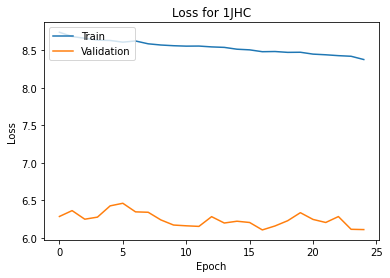

Training 2JHH out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 


Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping


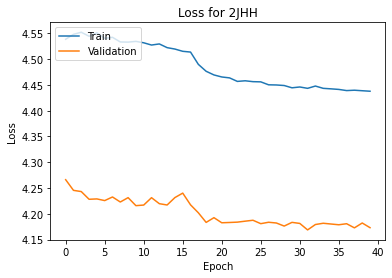

Training 1JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 


Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00135: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Restoring model weights from the end of the best epoch.
Epoch 00136: early stopping


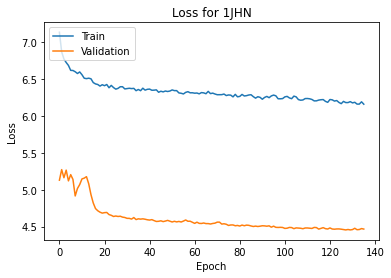

Training 2JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 


Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping


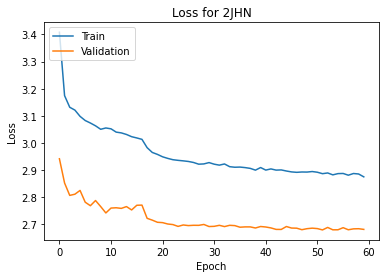

Training 2JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 


Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00055: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping


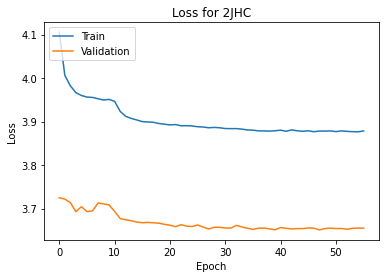

Training 3JHH out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 


Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping


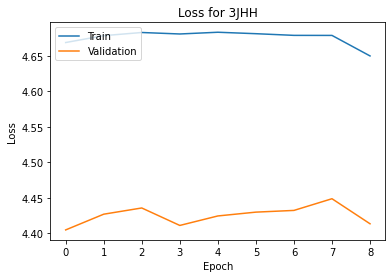

Training 3JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 


Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00077: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Restoring model weights from the end of the best epoch.
Epoch 00078: early stopping


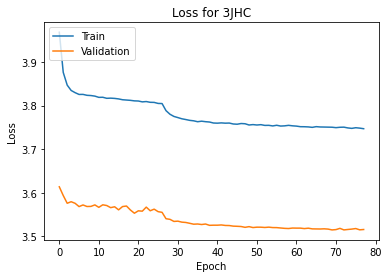

Training 3JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 


Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00093: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00101: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch.
Epoch 00102: early stopping


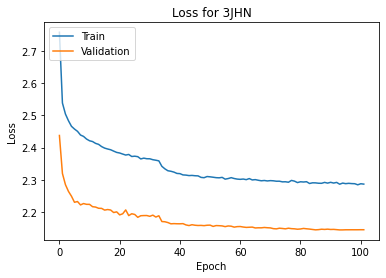

In [11]:
start_time=datetime.now()

for mol_type in mol_types:
  model_name_rd = ('/content/drive/MyDrive/data/trained_model/molecule_model_%s.hdf5' % mol_type)
  model_name_wrt = ('/content/drive/MyDrive/data/molecule_model_%s.hdf5' % mol_type)
  print('Training %s' % mol_type, 'out of', mol_types, '\n')
  
  df_train_=df_train[df_train["type"]==mol_type]
  df_test_=df_test[df_test["type"]==mol_type]
  
  input_features=["x_0","y_0","z_0","x_1","y_1","z_1","c_x","c_y","c_z", "distance", "atom_n"]
  
  input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))
  
  target_data=df_train_.loc[:,"scalar_coupling_constant"].values
  target_data_1=df_train_.loc[:,["charge_0","charge_1"]]
  target_data_2=df_train_.loc[:,["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]]
  target_data_3=df_train_.loc[:,["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]]
  
  m1=1
  m2=4
  m3=1
  target_data_1=m1*(StandardScaler().fit_transform(target_data_1))
  target_data_2=m2*(StandardScaler().fit_transform(target_data_2))
  target_data_3=m3*(StandardScaler().fit_transform(target_data_3))
  
  train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.1)
  
  train_input=input_data[train_index]
  cv_input=input_data[cv_index]
  train_target=target_data[train_index]
  cv_target=target_data[cv_index]
  train_target_1=target_data_1[train_index]
  cv_target_1=target_data_1[cv_index]
  train_target_2=target_data_2[train_index]
  cv_target_2=target_data_2[cv_index]
  train_target_3=target_data_3[train_index]
  cv_target_3=target_data_3[cv_index]
  test_input=input_data[len(df_train_):,:]

  nn_model=create_nn_model(train_input.shape[1])
  
  # If retrain==False, then we load a previous saved model as a starting point.
  if not retrain:
      nn_model = load_model(model_name_rd)
      
  nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])
  
  # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
  es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=8,verbose=1, mode='auto', restore_best_weights=True)
  # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
  rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=7, min_lr=1e-6, mode='auto', verbose=1)
  # Save the best value of the model for future use
  sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)

  history = nn_model.fit(train_input,[train_target,train_target_1,train_target_2,train_target_3], 
          validation_data=(cv_input,[cv_target,cv_target_1,cv_target_2,cv_target_3]), 
          callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)
  
  cv_predict=nn_model.predict(cv_input)
  plot_history(history, mol_type)
  
  accuracy=np.mean(np.abs(cv_target-cv_predict[0][:,0]))
  cv_score.append(np.log(accuracy))
  cv_score_total+=np.log(accuracy)
  
  # Predict on the test data set using our trained model
  test_predict=nn_model.predict(test_input)
  
  # for each molecule type we'll grab the predicted values
  test_prediction[df_test["type"]==mol_type]=test_predict[0][:,0]
  K.clear_session()

cv_score_total/=len(mol_types)


In [4]:
submit(test_prediction)

print ('Total training time: ', datetime.now() - start_time)

i=0
for mol_type in mol_types: 
  print(mol_type,": cv score is ",cv_score[i])
  i+=1
print("total cv score is",cv_score_total)

2505190 2505190
Total training time:  1:55:15.257224
1JHC : cv score is  1.191457049084099
2JHH : cv score is  -0.1608422689909677
1JHN : cv score is  0.8566260420904951
2JHN : cv score is  -0.004626501219063319
2JHC : cv score is  0.41892840983299606
3JHH : cv score is  0.010152636209554386
3JHC : cv score is  0.2568923348707452
3JHN : cv score is  -0.7633743432854347
total cv score is 0.22565166982405296
